In [1]:
# for folders one level below the heirarchy
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)
###########################################


from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *
from PIL import Image as image

import cv2
import numpy as np
import ctypes
from ctypes import *
from scipy import misc
from time import sleep
import csv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480


cupy not installed. Using numpy.


In [2]:
## Step 2: Trail run to troubleshoot camera linking, finding zeroth order point location, and making sure stuff runs. 
# The biggest challenge here is probably finding the 0th order and making sure the location is stable.
# If we are working in an unstable environment, might be worth using cv2 to find the location of 0th order spot.
# However, there are print lines scattered throughout the code to help pinpoint where things go FUBAR.


awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
success = ctypes.windll.user32.SetProcessDPIAware()
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
cam.start_live_video(framerate = "10Hz")
print("Camera Loaded")
RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\19x12_8bit_linearVoltage.lut")
print("Load LUT success")

Image = np.empty([width.value*height.value*3], np.uint8, 'C')
WFC = np.zeros([width.value*height.value*3], np.uint8, 'C')
openWFC = np.array(image.open("slm6287_at785_WFC.bmp")).flatten(order='C')
WFC[:] = openWFC

image_lib.Generate_Solid(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, c_uint(0), RGB)
print("Generate Image success")
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
print("Write Image success")


0
Camera Loaded
Created SDK
Load LUT success
Generate Image success
Write Image success


In [11]:
Image = np.empty([width.value*height.value*3], np.uint8, 'C')
WFC = np.zeros([width.value*height.value*3], np.uint8, 'C')
WFCimage = image.open("slm6287_at785_WFC.bmp")
openWFC = np.array(WFCimage).flatten(order='C')
WFC[:] = openWFC
reshaped_array = WFC.reshape((1200, 1920, 3))


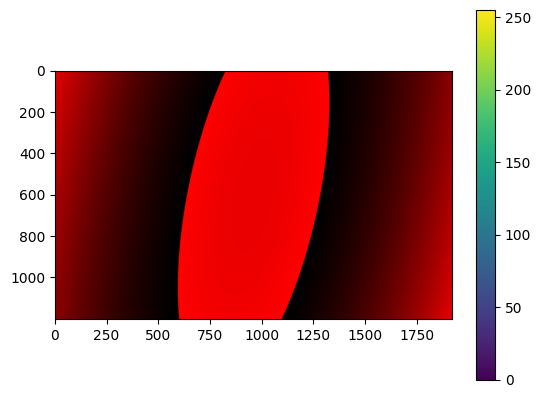

In [12]:
plt.imshow(reshaped_array)
plt.colorbar()

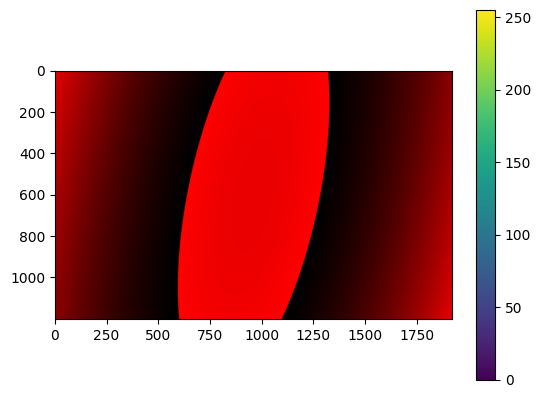

In [13]:
plt.imshow(WFCimage)
plt.colorbar()

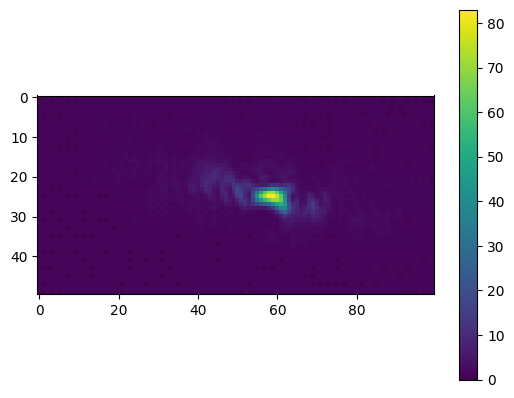

In [10]:
## Determine camera settings
PixelValueOne = c_uint(255)
PixelValueTwo = c_uint(100)
PixelsPerStripe = c_uint(16)
## Settings + Initialize camera
NumDataPoints = 256
NumRegions =1 ## If we need regional calibration, set this to 64
### numFrames determines how many times we will take a picture of a set diffraction grating. I recommend 3~5 to get a good average. 
numFrames = 3
AI_Intensities = np.zeros([NumRegions, NumDataPoints], np.float32, 'C')


# REMEMBER TO ADD IN THE WAVEFRONT CORRECTION
millisec = 10
exposure=f'{millisec}ms'

testpixelval = c_uint(255 - 20) # testmax
image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,0,c_uint(NumRegions),RGB)
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
sleep(0.03)
frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
plt.imshow(frame[550:600, 700:800])
plt.colorbar()


In [12]:
## NOTE TO SELF: WRITE SOME CODE HERE THAT WILL CORRECT FOR TOO LOW/HIGH EXPOSURE
millisec = 10
exposure=f'{millisec}ms'
ymin = 450
ymax =600
xmin = 700
xmax = 800


for region in range(0,NumRegions,1):
    # region = 3
    validregion = True
    print("Region: %d\n", region)
    exposure=f'{millisec}ms'
    # initial calibration
    ## Test max = 60, Test min = 110
    testpixelval = c_uint(255 - 60) # testmax
    image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    sleep(0.03)
    frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    testmaxval = np.max(frame[ymin:ymax, xmin:xmax])
    
    
    testpixelval = c_uint(255 - 110) # testmin
    image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    sleep(0.03)
    frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    testminval = np.max(frame[ymin:ymax, xmin:xmax])
    # if (10 > testminval or testmaxval < 230):
    #     millisec = 0.5
    # while 10 > testminval or testmaxval < 230:
    #     if millisec > 10:
    #         print("error")
    #         AI_Intensities[region, :] = 0
    #         validregion = False
    #     millisec += 0.1
    #     exposure=f'{millisec}ms'

    #     testpixelval = c_uint(255 - 60) # testmax
    #     image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    #     image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    #     slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    #     sleep(0.03)
    #     frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    #     testmaxval = np.max(frame[ymin:ymax, xmin:xmax])
        
        
    #     testpixelval = c_uint(255 - 110) # testmin
    #     image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
    #     image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
    #     slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
    #     sleep(0.03)
    #     frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
    #     testminval = np.max(frame[ymin:ymax, xmin:xmax])
        
        
    
    if validregion:
        for gray in range(0,NumDataPoints,1):
            # print("Gray: %d\r", gray)
            PixelValueTwo = c_uint(255-gray)
            image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
            image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
            slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
            sleep(0.03)
            net = 0
            for frames in range(0, numFrames, 1):
                #Important: exposure_time can be set to your liking, choose one that's best for saturation
                frame = cam.grab_image(timeout='100s', copy=True, exposure_time=exposure)
                numpix = 0 
                #this region has to be handled by you!!! Find the region where the 0th order / 1st order spot is
                #You can average over nearby pixels, take the max value, or something else. 
                #You can find where the desired spot is by passing a diffraction grating to the SLM manually and opening the Thorlabs camera in Python. Then translate camera to an array, find points on array, and put in coords. Code for this should be available above.
                net += np.max(frame[ymin:ymax, xmin:xmax])
                print(net)
            AI_Intensities[region, gray] = net / numFrames
            # this will give you an indicator of your pixel values. make sure there's no over/under saturation!



Region: %d
 0
2
4
6
2
4
6
2
4
6
2
4
6
2
4
6
2
5
8
3
6
9
4
8
12
5
10
15
6
12
18
8
15
22
9
18
28
9
20
30
12
24
37
13
27
41
16
31
46
17
33
49
20
38
57
21
42
61
23
43
65
25
50
73
26
49
76
29
55
84
30
64
94
32
65
98
36
72
108
37
75
111
36
76
114
43
84
128
47
95
145
52
100
149
45
96
146
52
105
156
55
110
165
54
112
170
58
115
171
63
124
184
62
123
191
65
140
209
70
138
213
74
147
220
79
154
235
84
167
248
85
172
257
89
178
266
94
190
279
97
194
292
101
200
301
101
209
313
109
215
325
109
217
329
114
229
344
119
242
365
119
241
363
119
242
367
127
255
381
131
257
386
131
260
390
138
271
406
137
269
398
134
269
403
137
277
419
139
279
422
142
282
425
147
288
425
145
289
427
142
286
432
146
292
429
137
267
404
135
278
420
135
273
410
131
259
390
132
262
388
127
258
386
123
240
372
123
245
363
113
228
340
116
230
349
107
213
320
102
206
306
97
194
289
90
182
272
89
177
264
83
167
250
81
160
239
70
131
200
64
126
183
71
134
187
49
102
154
48
98
146
44
92
135
39
77
122
40
74
110
31
63
96
30
56
84


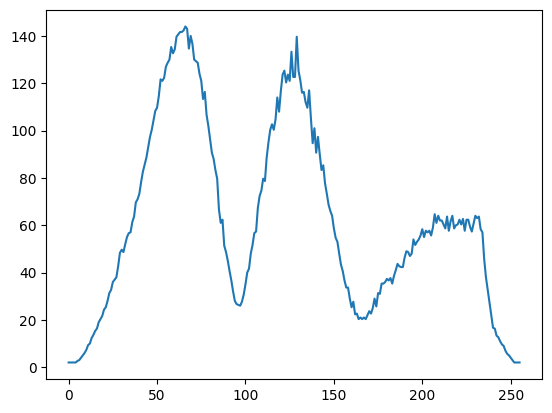

In [13]:
plt.plot(AI_Intensities[0])

In [14]:
AI_Intensities = AI_Intensities[0] / np.max(AI_Intensities[0]) * 255
AI_Intensities.flatten()
numbers = np.arange(256)
csvdata = np.stack((numbers,AI_Intensities),axis=1)
np.savetxt('Raw0.csv',csvdata, delimiter = ",", fmt='%s')

In [19]:
np.savez_compressed("globalcalibrationraw/globalcalibration.npz", array1=AI_Intensities)
filename = f"globalcalibrationraw/Raw0.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    for datapoints in range(NumDataPoints):
        writer.writerow([datapoints, AI_Intensities[datapoints]])
